### Filtering Evaluation Results

After running the `eval` module of TarPass on a specific model, this notebook can be used to perform stepwise filtering by specifying a particular target and selecting specific evaluation metrics.


In [37]:
from analysis.collect_eval import collect_readable
from pathlib import Path
import operator

ops = {
    '>=': operator.ge,
    '<=': operator.le,
    '>': operator.gt,
    '<': operator.lt,
    '==': operator.eq,
    '!=': operator.ne
}

In [38]:
def filter(value, condition_dict) -> bool:
    if value is None:
        return False
    operator, thres = condition_dict
    return ops[operator](value, thres)

def filter_stats(results, conditions) -> tuple[list, dict]:
    filtered = results.copy()
    filter_stats = {}
    
    for cls, subclses in conditions.items():
        filter_stats[cls] = {}
        for metrics in subclses.values():
            for m in metrics:
                filter_stats[cls][m] = 0
    
    for cls, subclses in conditions.items():
        for subcls, metrics in subclses.items():
            for metric, condition in metrics.items():
                new_filtered = []
                
                for result in filtered:
                    if cls not in result:
                        continue
                    if subcls not in result[cls]:
                        continue
                        
                    cls_data = result[cls][subcls]
                    
                    if metric not in cls_data:
                        raise ValueError(f"Metric '{metric}' not found in results under '{cls} -> {subcls}'")
                    
                    value = cls_data.get(metric, None)
                    
                    if filter(value, condition):
                        filter_stats[cls][metric] += 1
                        new_filtered.append(result)
                filtered = new_filtered
    return filtered, filter_stats

#### Specifying Model and Target

In [39]:
model = 'Drugflow'
target = 'JAK2'
results = collect_readable(Path(f'{model}/{target}/results'))

#### Specify Filtering Criteria:

Filtering conditions can be provided either via a JSON file in the first two cells below, or directly as a dictionary in the third cell.  
Please note that when modifying the custom JSON file, it must strictly follow the format shown in the third cell.

In [40]:
# from utils.io import dump_json, load_json

# di = {}
# for cls in list((r:=results[0]).keys())[1:]:
#     di[cls] = {}
#     subclses = r[cls]
#     for subcls, metrics in subclses.items():
#         di[cls][subcls] = {}
#         for metric in metrics.keys():
#             di[cls][subcls][metric] = ()

# dump_json('filter_conditions.json', di)

In [41]:
# # Modify 'filter_conditions.json' to set your filtering conditions
# conditions = load_json('filter_conditions.json')

In [42]:
conditions = {
    # Redock results filter
    'Dock': {
        'numerical': {
            'score': ['<=', -9.0],
            'fully_matched': ['==', True],
        }, 
        'interactions': {}
        },

    # Rescore reults filter, which available model is 3D
    'Score':{
        'numerical': {},
        'interactions': {}
        },

    # Properties filter
    'Prop': {
        'Descriptors': {},
        'Structural': {
            'all_common': ['==', True],
            'unexpect rings': ['==', 0],
        },
        'Alerts': {
            'sa_score': ['<=', 4.0],
            'qed': ['>=', 0.5],
            'lipinski': ['>', 3],
            'PAINS_alert': ['==', 0],
            'SureChEMBL_alert': ['==', 0],
            'Glaxo_alert': ['==', 0]
        }
        }
}

In [ ]:
filtered, stats = filter_stats(results, conditions)

In [45]:
import pandas as pd
df_di = {'Initial': len(results)}
for cls, subclses in stats.items():
    for metric, count in subclses.items():
        df_di[f'{cls}-{metric}'] = count
df = pd.DataFrame.from_dict(df_di, orient='index', columns=[model])
df.to_csv(f'{model}_{target}_filter_stats.csv')

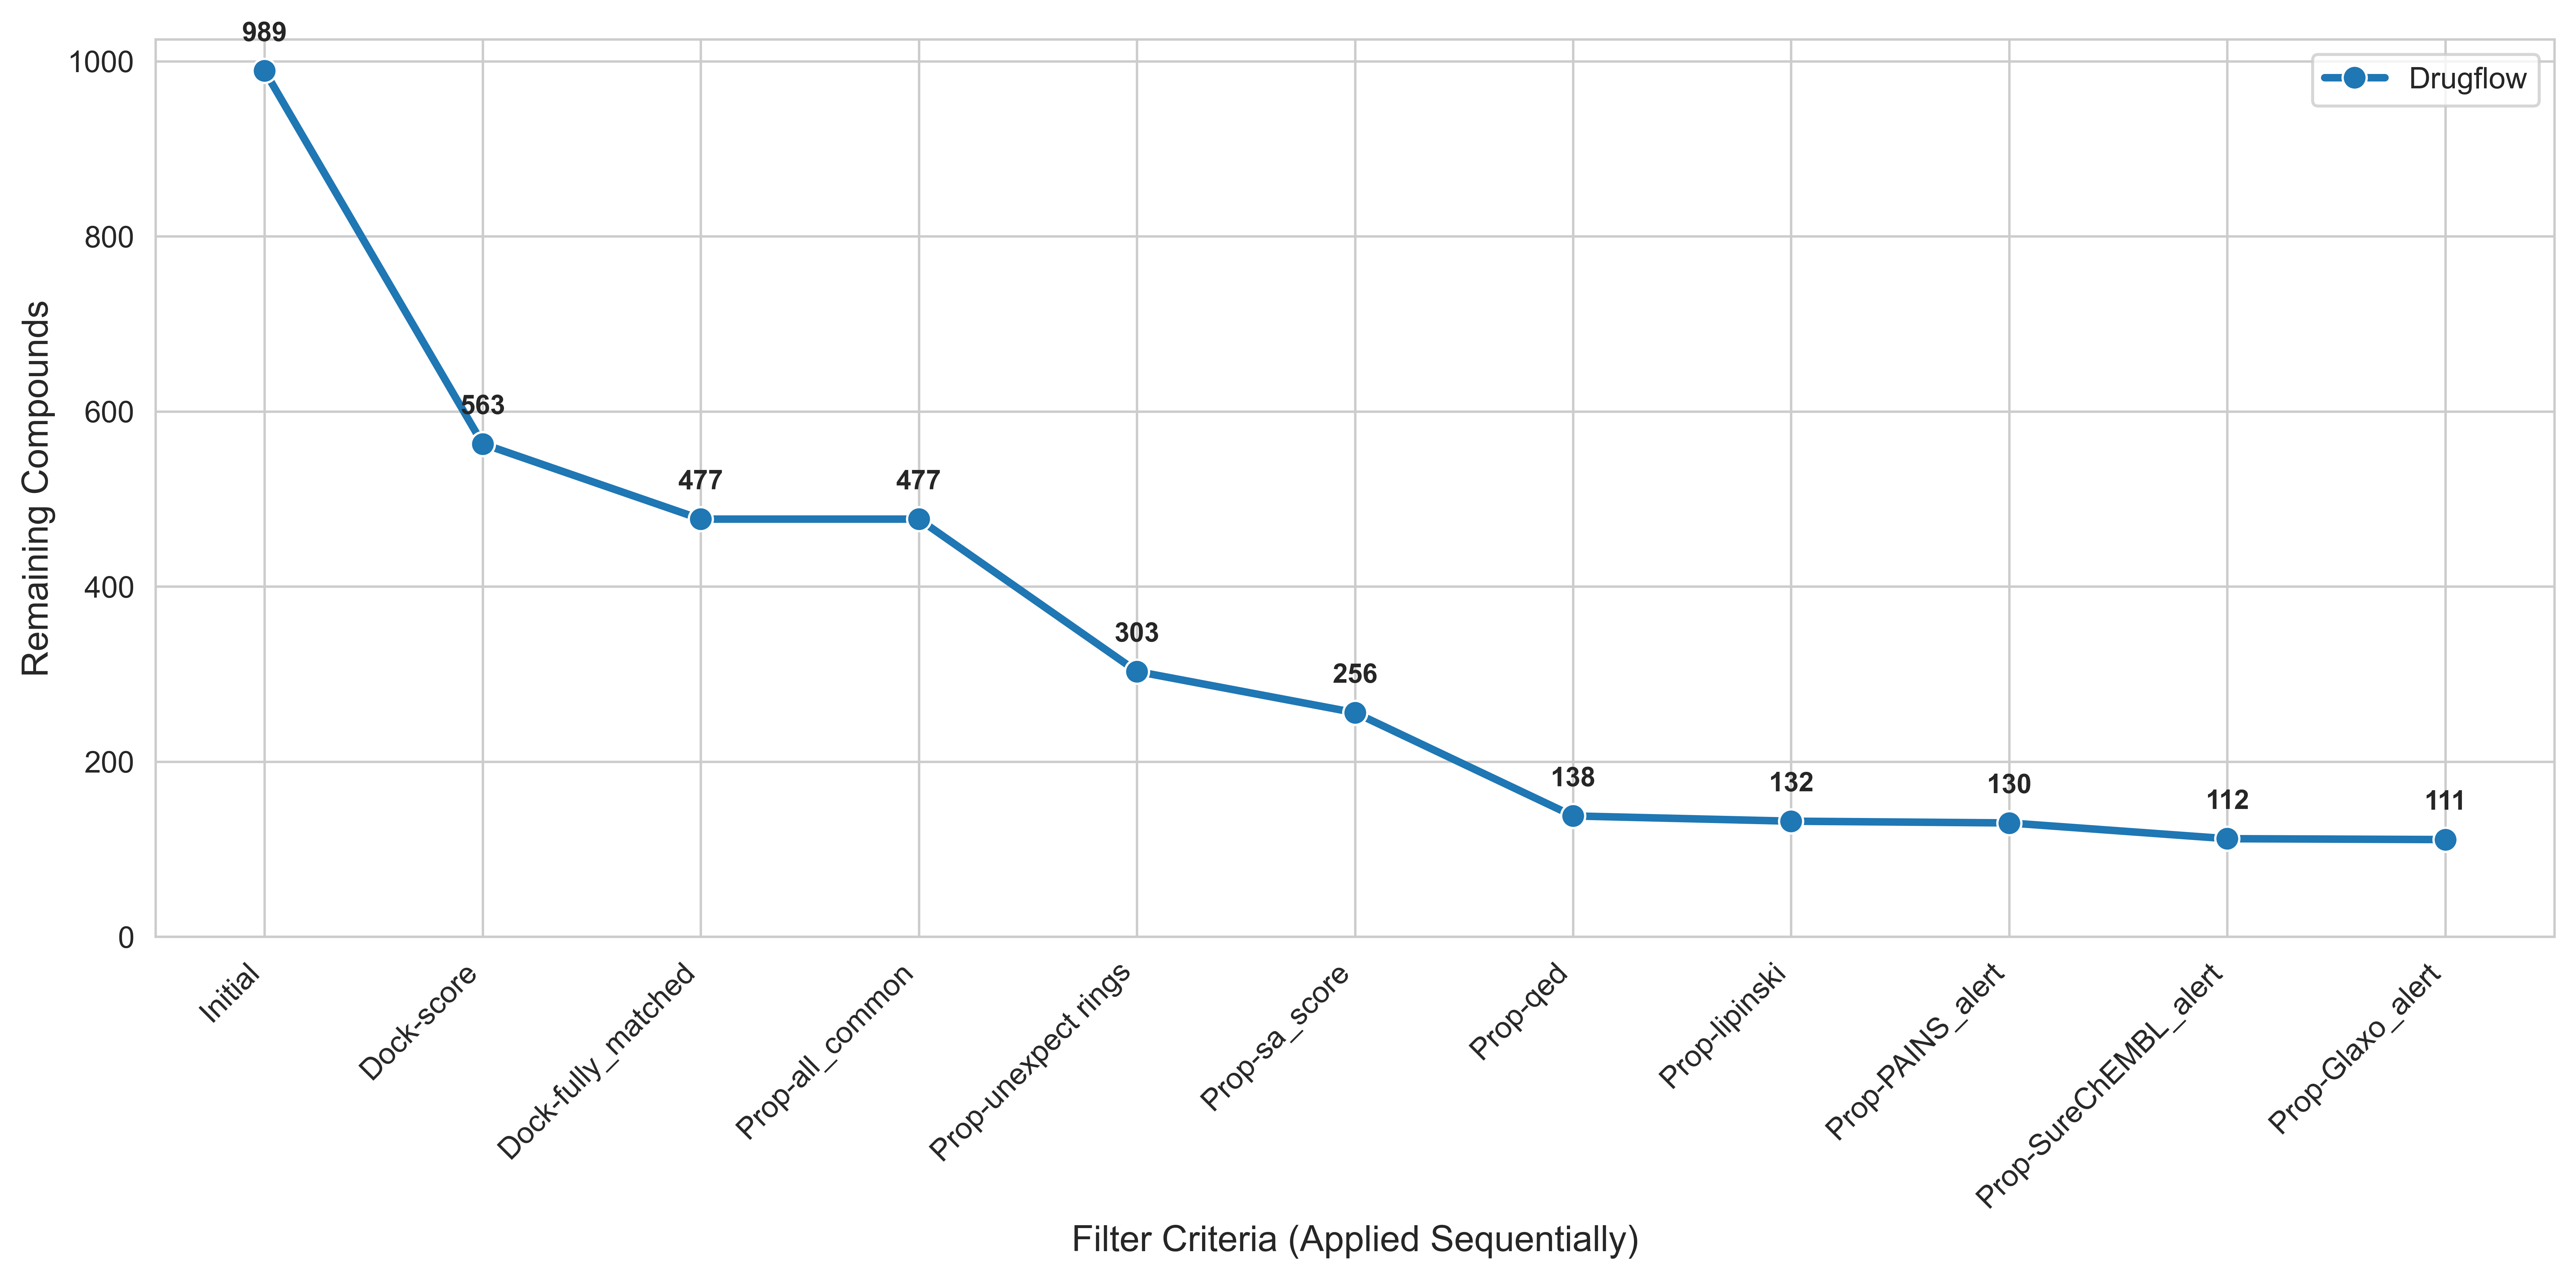

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6), dpi=600)

ax = sns.lineplot(x=range(len(df)),
                  y=df[model],
                  marker='o',
                  linewidth=2.5,
                  markersize=8)

ax.set_xticks(range(len(df)))
ax.set_xticklabels(df.index, rotation=45, ha='right')

plt.xlabel('Filter Criteria (Applied Sequentially)', fontsize=12)
plt.ylabel('Remaining Compounds', fontsize=12)
plt.ylim(0, 1025)

for i, v in enumerate(df[model]):
    plt.annotate(f'{v}', (i, v), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

plt.legend([model])
plt.tight_layout()